In [1]:
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-bright')

In [2]:
def grid_generation(M_x,M_y,L,H):
   del_x=L/(M_x-1);
   del_y=H/(M_y-1);
   x_p=np.linspace(0,L,M_x);
   y_p=np.linspace(0,H,M_y);
   [X,Y]=np.meshgrid(x_p,y_p);
   ita=del_x/ del_y
   return del_x,del_y,X,Y,ita

In [3]:
def TDMA(CAE,CAW,CAP,S,M,Value):
	A=np.zeros(M)
	B=np.zeros(M)
	A[0]=CAE[0]/CAP[0]
	B[0]=S[0]/CAP[0]
	for i in range(1,M-1):
		A[i]=CAE[i]/(CAP[i]-CAW[i]*A[i-1])
		B[i]=(S[i]+CAW[i]*B[i-1])/(CAP[i]-CAW[i]*A[i-1])
    
	for i in range(M-2,0,-1):
		Value[i]=A[i]*Value[i+1]+B[i]

	return Value

In [4]:
def ADI(Value,M_x,M_y,CAE1,CAW1,CAN1,CAS1,CAP1,S):
	while 1==1:
		Value_old=np.array(Value)
		for j in range(1,M_y-1):
			# I-Sweep
			Value_x=Value[j,:]
			S_modi1=CAN1[j,:]*Value[j+1,:]+CAS1[j,:]*Value[j-1,:]+S[j,:]
			Value[j,:]=TDMA(CAE1[j,:],CAW1[j,:],CAP1[j,:],S_modi1,M_x,Value_x)
		for i in range(1,M_x-1):
			# J sweep
			Value_y=Value[:,i]
			S_modi=CAW1[:,i]*Value[:,i-1]+CAE1[:,i]*Value[:,i+1]+S[:,i]
			Value[:,i]=TDMA(CAN1[:,i],CAS1[:,i],CAP1[:,i],S_modi,M_y,Value_y)
		if np.amax(np.absolute(Value_old-Value))<10**(-5):
			break
	
	return Value 

In [6]:
def main(M_x,M_y,L,H,U_inf,neu,alpha):
  del_x,del_y,x_p,y_p,ita=grid_generation(M_x,M_y,L,H)

  CAW1=np.ones((M_y,M_x))
  CAE1=np.ones((M_y,M_x))
  CAN1=np.ones((M_y,M_x))
  CAS1=np.ones((M_y,M_x))

  CAN1=CAN1*(ita**2)
  CAS1=CAS1*(ita**2)
  CAP1=CAW1+CAE1+CAN1+CAS1

  CAP1[:,0]=1
  CAW1[:,0]=0
  CAE1[:,0]=0
  CAN1[:,0]=0
  CAS1[:,0]=0

  CAP1[0,:]=1
  CAW1[0,:]=0
  CAE1[0,:]=0
  CAN1[0,:]=0
  CAS1[0,:]=0

  CAP1[:,M_x-1]=1
  CAW1[:,M_x-1]=0
  CAE1[:,M_x-1]=0
  CAN1[:,M_x-1]=0
  CAS1[:,M_x-1]=0

  CAP1[M_y-1,:]=1
  CAW1[M_y-1,:]=0
  CAE1[M_y-1,:]=0
  CAN1[M_y-1,:]=0
  CAS1[M_y-1,:]=0
  def CAE2(u,neu):
      return 1-(u*(del_x/(2*neu)))
  def CAW2(u,neu):
      return 1+(u*(del_x/(2*neu)))
  def CAN2(v,neu,ita):
      return (ita**2) *(1-v*(del_x/(2*neu)))  
  def CAS2(v,neu,ita):
      return (ita**2) *(1+v*(del_x/(2*neu)))
	# initial guess
  psi=np.zeros((M_y,M_x)) 
  ohm=np.zeros((M_y,M_x))
  for i in range(0,M_y):
    ohm[i,:]=-((2*U_inf)/del_y)*(i/M_y)*0
  u=np.zeros((M_y,M_x))
  u[M_y-1,:]=U_inf
  v=np.zeros((M_y,M_x))
  p=0
  while 1==1:
   
		# u velocity
    for j in range(1,M_y-1):
      u[j,:]=(psi[j+1,:]-psi[j-1,:])/(2*del_y)
       
    # v velocity
    for i in range(1,M_x-1):
      v[:,i]=-(psi[:,i+1]-psi[:,i-1])/(2*del_x)
    
    
    # psi (ADI Scheme)
    psi_old=np.array(psi)
    S_psi=(del_x**2)*ohm
    psi=ADI(psi,M_x,M_y,CAE1,CAW1,CAN1,CAS1,CAP1,S_psi)
    psi=alpha*psi+(1-alpha)*psi_old

    # ohm(ADI Scheme)
    ohm_old=np.array(ohm)
    CAE3=CAE2(u,neu)
    CAW3=CAW2(u,neu)
    CAN3=CAN2(v,neu,ita)
    CAS3=CAS2(v,neu,ita)
    CAP3=CAE3+CAW3+CAN3+CAS3 

    ##coefficient at boundaries
    CAP3[:,0]=1
    CAW3[:,0]=0
    CAE3[:,0]=0
    CAN3[:,0]=0
    CAS3[:,0]=0

    CAP3[0,:]=1
    CAW3[0,:]=0
    CAE3[0,:]=0
    CAN3[0,:]=0
    CAS3[0,:]=0

    CAP3[:,M_x-1]=1
    CAW3[:,M_x-1]=0
    CAE3[:,M_x-1]=0
    CAN3[:,M_x-1]=0
    CAS3[:,M_x-1]=0

    CAP3[M_y-1,:]=1
    CAW3[M_y-1,:]=0
    CAE3[M_y-1,:]=0
    CAN3[M_y-1,:]=0
    CAS3[M_y-1,:]=0

    S_ohm=np.zeros((M_y,M_x))
    for j in range(1,M_y-1):
      ohm[j,M_x-1]=-(2/(del_x**2))*psi[j,M_x-2]
      ohm[j,0]=-(2/del_x**2)*psi[j,1]
    for i in range(1,M_x-1):
      ohm[0,i]=-(2/del_y**2)*psi[1,i]
      ohm[M_y-1,i]=-(2*psi[M_y-2,i]+2*U_inf*del_y)/(del_y**2)
    
    ohm=ADI(ohm,M_x,M_y,CAE3,CAW3,CAN3,CAS3,CAP3,S_ohm)
    ohm=alpha*ohm+(1-alpha)*ohm_old

    if np.amax(abs(ohm-ohm_old))<10**(-10):
      break
    p=p+1
    #print(p)
  return psi,ohm,u,v,x_p,y_p

In [7]:
L=1;
H=1;
U_inf=1;
M_x=11;
M_y=11;
neu=0.01;
alpha=0.1;
psi,ohm,u1,v1,X,Y=main(M_x,M_y,L,H,U_inf,neu,alpha)

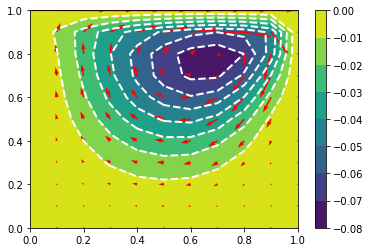

In [8]:
plt.figure(1)
plt.contourf(X,Y,psi)
plt.colorbar()
plt.contour(X,Y,psi,colors='w',linewidths=2)
plt.quiver(X,Y,u1,v1,color='r')
plt.show()

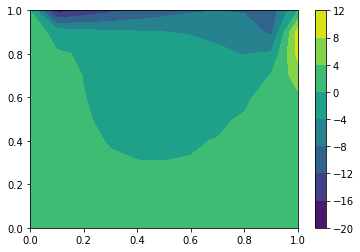

In [9]:
plt.figure(2)
plt.contourf(X,Y,ohm)
plt.colorbar()

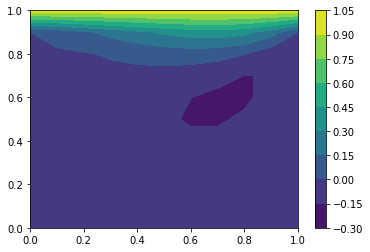

In [10]:
plt.figure(3)
plt.contourf(X,Y,u1)
plt.colorbar()

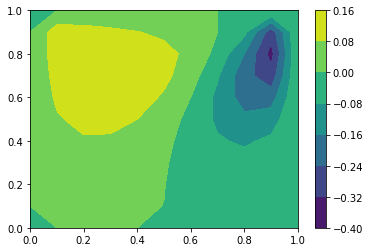

In [11]:
plt.figure(4)
plt.contourf(X,Y,v1)
plt.colorbar()
plt.show()

In [12]:
L=1;
H=1;
U_inf=1;
M_x=31;
M_y=31;
neu=0.01;
alpha=0.1;
psi,ohm,u2,v2,X,Y=main(M_x,M_y,L,H,U_inf,neu,alpha)

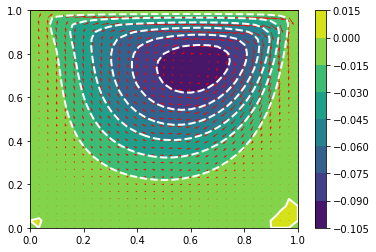

In [13]:
plt.figure(1)
plt.contourf(X,Y,psi)
plt.colorbar()
plt.contour(X,Y,psi,colors='w',linewidths=2)
plt.quiver(X,Y,u2,v2,color='r')
plt.show()

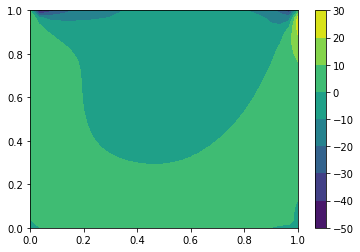

In [14]:
plt.figure(2)
plt.contourf(X,Y,ohm)
plt.colorbar()

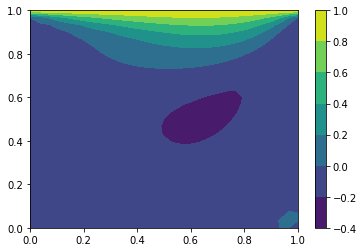

In [15]:
plt.figure(3)
plt.contourf(X,Y,u2)
plt.colorbar()

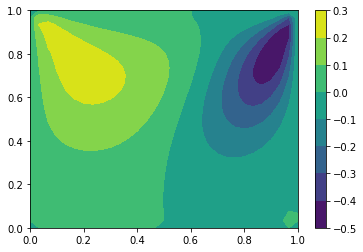

In [16]:
plt.figure(4)
plt.contourf(X,Y,v2)
plt.colorbar()
plt.show()

In [17]:
L=1;
H=1;
U_inf=1;
M_x=51;
M_y=51;
neu=0.01;
alpha=0.1;
psi,ohm,u3,v3,X,Y=main(M_x,M_y,L,H,U_inf,neu,alpha)

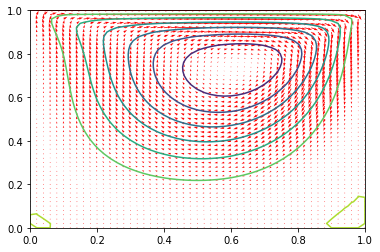

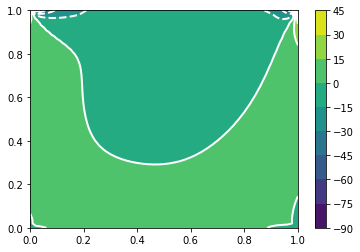

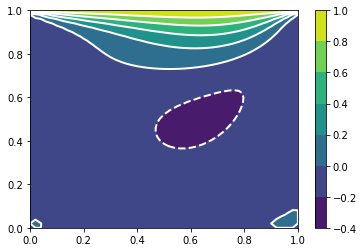

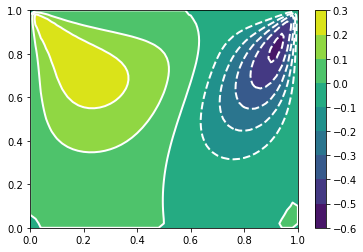

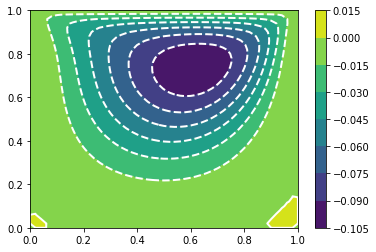

In [18]:
plt.figure(1)
plt.contour(X,Y,psi)
plt.quiver(X,Y,u3,v3,color='r')
plt.show()
plt.figure(2)
plt.contourf(X,Y,ohm)
plt.colorbar()
plt.contour(X,Y,ohm,colors='w',linewidths=2)

plt.figure(3)
plt.contourf(X,Y,u3)
plt.colorbar()
plt.contour(X,Y,u3,colors='w',linewidths=2)

plt.figure(4)
plt.contourf(X,Y,v3)
plt.colorbar()
plt.contour(X,Y,v3,colors='w',linewidths=2)

plt.figure(5)
plt.contourf(X,Y,psi)
plt.colorbar()
plt.contour(X,Y,psi,colors='w',linewidths=2)

plt.show()

In [19]:
u_11=u1[:,6]
u_31=u2[:,16]
u_51=u3[:,26]
x1=np.linspace(0,1,11)
x2=np.linspace(0,1,31)
x3=np.linspace(0,1,51)
x_bench=np.linspace(0,1,17)
u_bench=[0, -0.04197, -0.07712,-0.10981,-0.14193,-0.17271,-0.19847,-0.21296,-0.20914,-0.18208, -0.13125, -0.060245, 0.027874, 0.140425, 0.310557, 0.597466, 1.0000]

<function matplotlib.pyplot.show(close=None, block=None)>

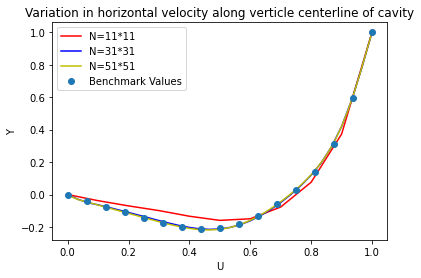

In [20]:
plt.plot(x1,u_11,'r')
plt.plot(x2,u_31,'b')
plt.plot(x3,u_51,'y')
plt.plot(x_bench,u_bench,'o')
plt.legend(['N=11*11','N=31*31','N=51*51','Benchmark Values'])
plt.title('Variation in horizontal velocity along verticle centerline of cavity')
plt.xlabel('U')
plt.ylabel('Y')
plt.show

In [21]:
v_11=v1[6,:]
v_31=v2[16,:]
v_51=v3[26,:]
v_bench=[0,0.094807,0.14924,0.174342,0.17924,0.16913,0.1457,0.10877,0.05753,-0.007748,-0.08406,-0.16301,-0.2278,-0.25376,-0.2186,-0.1233,0]

<function matplotlib.pyplot.show(close=None, block=None)>

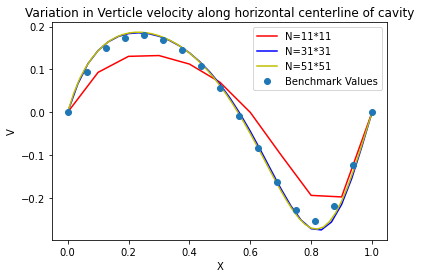

In [22]:
plt.plot(x1,v_11,'r')
plt.plot(x2,v_31,'b')
plt.plot(x3,v_51,'y')
plt.plot(x_bench,v_bench,'o')
plt.legend(['N=11*11','N=31*31','N=51*51','Benchmark Values'])
plt.title('Variation in Verticle velocity along horizontal centerline of cavity')
plt.xlabel('X')
plt.ylabel('V')
plt.show

In [ ]:
L=1;
H=1;
U_inf=1;
M_x=1024;
M_y=1024;
neu=0.01;
alpha=0.1;
psi,ohm,u3,v3,X,Y=main(M_x,M_y,L,H,U_inf,neu,alpha)

In [ ]:
plt.figure(1)
plt.contour(X,Y,psi)
plt.quiver(X,Y,u3,v3,color='r')
plt.show()
plt.figure(2)
plt.contourf(X,Y,ohm)
plt.colorbar()
plt.contour(X,Y,ohm,colors='w',linewidths=2)

plt.figure(3)
plt.contourf(X,Y,u3)
plt.colorbar()
plt.contour(X,Y,u3,colors='w',linewidths=2)

plt.figure(4)
plt.contourf(X,Y,v3)
plt.colorbar()
plt.contour(X,Y,v3,colors='w',linewidths=2)

plt.figure(5)
plt.contourf(X,Y,psi)
plt.colorbar()
plt.contour(X,Y,psi,colors='w',linewidths=2)

plt.show()